In [1]:
import pandas as pd
import numpy as np
import string

import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
# from gensim.matutils import softcossim
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import pickle
import math
import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchtext.vocab as torchvocab
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('hotel.csv') 
print(data.shape)
reviews = data['reviews']
print(reviews.shape)

(31999, 10)
(31999,)


In [3]:
validationdata = pd.read_csv('validation.csv') 
print(validationdata.shape)
validationreviews = validationdata['reviews']
print(validationreviews.shape)
print(validationdata.head())


(6296, 10)
(6296,)
  aspects1  aspects1_rating  aspects2  aspects2_rating aspects3  \
0    Value                2  Location                3    Rooms   
1    Value                5  Location                5    Rooms   
2    Value                5  Location                5    Rooms   
3    Value                3  Location                4    Rooms   
4    Value                3  Location                5    Rooms   

   aspects3_rating     aspects4  aspects4_rating  rating  \
0                2  Cleanliness                2       2   
1                5  Cleanliness                5       4   
2                5  Cleanliness                5       5   
3                4  Cleanliness                4       3   
4                4  Cleanliness                4       4   

                                             reviews  
0  I stayed at this hotel for two long and not so...  
1  We've stayed here many times before and the Fr...  
2  The Book Cadillac is a great modern hotel in a...

In [4]:
traindata = pd.read_csv('train.csv') 
print(traindata.shape)
trainreviews = traindata['reviews']
print(trainreviews.shape)

(19444, 10)
(19444,)


In [5]:
testdata = pd.read_csv('test.csv') 
print(testdata.shape)
testreviews = testdata['reviews']
print(testreviews.shape)

(6257, 10)
(6257,)


In [6]:
def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [7]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


In [8]:
def pad_and_truncate(sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
    x = (np.ones(maxlen) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-maxlen:]
    else:
        trunc = sequence[:maxlen]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x


In [9]:
class Tokenizer(object):
    def __init__(self, max_seq_len):
        self.max_seq_len = max_seq_len
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 1

    def fit_on_text(self, text):
        words = preprocess(text)
        for word in words:
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def text_to_sequence(self, text, reverse=False, padding='post', truncating='post'):
        words = preprocess(text)
        unknownidx = len(self.word2idx)+1
        sequence = [self.word2idx[w] if w in self.word2idx else unknownidx for w in words]
        if len(sequence) == 0:
            sequence = [0]
        if reverse:
            sequence = sequence[::-1]
        return pad_and_truncate(sequence, self.max_seq_len, padding=padding, truncating=truncating)


In [10]:
max_seq_len = 200
embed_dim = 300
hidden_dim = 300
polarities_dim = 2
glove_fname = 'glove.42B.300d.txt' 


In [11]:
def build_tokenizer(dataset, max_seq_len):
    tokenizer = Tokenizer(max_seq_len)
    for data in dataset:
        tokenizer.fit_on_text(data)
    return tokenizer

In [12]:
tokenizer = build_tokenizer(dataset = reviews, max_seq_len = max_seq_len)
train_tokenizer = build_tokenizer(dataset = trainreviews, max_seq_len = max_seq_len)
validation_tokenizer = build_tokenizer(dataset = validationreviews, max_seq_len = max_seq_len)
test_tokenizer = build_tokenizer(dataset = testreviews, max_seq_len = max_seq_len)


In [13]:
word2idx = tokenizer.word2idx
train_word2idx = train_tokenizer.word2idx
validation_word2idx = validation_tokenizer.word2idx
test_word2idx = test_tokenizer.word2idx


In [14]:
def load_word_vec(path, word2idx=None):
    fin = open(path, 'r', encoding='utf-8', newline='\n', errors='ignore')
    word_vec = {}
    for line in fin:
        tokens = line.rstrip().split()
        if word2idx is None or tokens[0] in word2idx.keys():
            word_vec[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    return word_vec


In [15]:
word_vec = load_word_vec(glove_fname, word2idx)

In [16]:
def build_embedding_matrix(word2idx, word_vec, embed_dim):
    embedding_matrix = np.zeros((len(word2idx)+2, embed_dim))
    for word, i in word2idx.items():
        vec = word_vec.get(word)
        if vec is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = vec
    return embedding_matrix

In [17]:
embedding_matrix = build_embedding_matrix(word2idx, word_vec, embed_dim)


In [18]:
def polarity(data):
    if(data>3):
        newdata=1
    else:
        newdata=0
    return newdata

In [19]:
class CreateDataset(Dataset):
    def __init__(self, dataset, sentence_tokenizer):
        
        all_data = []
        reviews = dataset['reviews']
        value_ratings = dataset['aspects1_rating']
        atmosphere_ratings = dataset['aspects2_rating']
        service_ratings = dataset['aspects3_rating']
        food_ratings = dataset['aspects4_rating']
        ratings = dataset['rating']
        
        for i in range(len(reviews)):
            
            review = reviews[i]
            review_token = preprocess(review)
            review_indices = sentence_tokenizer.text_to_sequence(review)
            
            value_rating = polarity(value_ratings[i])
            atmosphere_rating = polarity(atmosphere_ratings[i])
            service_rating = polarity(service_ratings[i])
            food_rating = polarity(food_ratings[i])
            
            rating = polarity(ratings[i])
            
            newdata = {
                #'review': review,
                #'review_token': review_token,
                'review_indices': review_indices, 
                'value_rating': value_rating,
                'atmosphere_rating': atmosphere_rating,
                'service_rating': service_rating,
                'food_rating': food_rating,
                'rating': rating,
                }

            all_data.append(newdata)

        self.data = all_data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)



In [20]:
trainset = CreateDataset(traindata,train_tokenizer)
validationset = CreateDataset(validationdata,validation_tokenizer)
testset = CreateDataset(testdata,test_tokenizer)


In [21]:
print(len(trainset))
print(len(validationset))
print(len(testset))

19444
6296
6257


In [22]:
testset[5]

{'review_indices': array([82,  7, 83, 46, 84, 10, 85, 86, 87, 88, 89, 90, 91, 61,  7, 92,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64),
 'value_rating': 1,
 'atmosphere_rating': 1,
 'service_rating': 0,
 'fo

In [23]:
batch_size = 64

In [24]:
train_data_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(dataset=validationset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)


In [25]:
class DynamicLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bias=True, batch_first=True, dropout=0,
                 bidirectional=False, only_use_last_hidden_state=False):
        """
        LSTM which can hold variable length sequence, use like TensorFlow's RNN(input, length...).

        :param input_size:The number of expected features in the input x
        :param hidden_size:The number of features in the hidden state h
        :param num_layers:Number of recurrent layers.
        :param bias:If False, then the layer does not use bias weights b_ih and b_hh. Default: True
        :param batch_first:If True, then the input and output tensors are provided as (batch, seq, feature)
        :param dropout:If non-zero, introduces a dropout layer on the outputs of each RNN layer except the last layer
        :param bidirectional:If True, becomes a bidirectional RNN. Default: False
        """
        super(DynamicLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.batch_first = batch_first
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.only_use_last_hidden_state = only_use_last_hidden_state
        
        self.lstm = nn.LSTM(
         input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
         bias=bias, batch_first=batch_first, dropout=dropout, bidirectional=bidirectional)  


    def forward(self, x, x_len):
        x_sort_idx = torch.sort(-x_len)[1].long()
        x_unsort_idx = torch.sort(x_sort_idx)[1].long()
        x_len = x_len[x_sort_idx]
        x = x[x_sort_idx]
        
        """pack"""
        x_emb_p = torch.nn.utils.rnn.pack_padded_sequence(x, x_len, batch_first=self.batch_first)
        
        # process using the selected RNN
        out_pack, (ht, ct) = self.lstm(x_emb_p, None)
   
        """unsort: h"""
        ht = torch.transpose(ht, 0, 1)[x_unsort_idx]  
        # (num_layers * num_directions, batch, hidden_size) -> (batch, ...)
        ht = torch.transpose(ht, 0, 1)

        if self.only_use_last_hidden_state:
            return ht
        else:
            """unpack: out"""
            # (sequence, lengths)
            out = torch.nn.utils.rnn.pad_packed_sequence(out_pack, batch_first=self.batch_first)           
            out = out[0]  
            out = out[x_unsort_idx]
            
            """unsort: out c"""
            # (num_layers * num_directions, batch, hidden_size) -> (batch, ...)
            ct = torch.transpose(ct, 0, 1)[x_unsort_idx]  
            ct = torch.transpose(ct, 0, 1)

            return out, (ht, ct)



In [26]:
class BiLSTM(nn.Module):
    def __init__(self,embedding_matrix, embed_dim, hidden_dim ,polarities_dim, device):
        
        super(BiLSTM, self).__init__()
        
        self.embed = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.lstm1 = DynamicLSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True, dropout=0.5)
        self.lstm2 = DynamicLSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True, dropout=0.5)
        self.lstm3 = DynamicLSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True, dropout=0.5)
        self.lstm4 = DynamicLSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True, dropout=0.5)
        # self.lstm = DynamicLSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=True, dropout=0.5)
        
        self.dense1 = nn.Linear(hidden_dim, polarities_dim)
        self.dense2 = nn.Linear(hidden_dim, polarities_dim)
        self.dense3 = nn.Linear(hidden_dim, polarities_dim)
        self.dense4 = nn.Linear(hidden_dim, polarities_dim)
        self.dense = nn.Linear(hidden_dim*4, polarities_dim)
   
    def forward(self,review_indices):
        
        text_raw_indices = review_indices
        x = self.embed(text_raw_indices)
        x_len = torch.sum(text_raw_indices != 0, dim=-1)
        
        _, (h_n1, _) = self.lstm1(x, x_len)
        _, (h_n2, _) = self.lstm2(x, x_len)
        _, (h_n3, _) = self.lstm3(x, x_len)
        _, (h_n4, _) = self.lstm4(x, x_len)
        #  _, (h_n, _) = self.lstm(x, x_len)
        
        out1 = self.dense1(h_n1[0])
        out2 = self.dense2(h_n2[0])
        out3 = self.dense3(h_n3[0])
        out4 = self.dense4(h_n4[0])
        h_n = torch.cat((h_n1[0],h_n2[0],h_n3[0],h_n4[0]),1) 
        out = self.dense(h_n)
    
        return out1,out2,out3,out4,out

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
mymodel = BiLSTM(embedding_matrix, embed_dim, hidden_dim, polarities_dim, device)
mymodel = mymodel.to(device)
mymodel

C:\Users\Mansi\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


BiLSTM(
  (embed): Embedding(17560, 300)
  (lstm1): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm2): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm3): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm4): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (dense1): Linear(in_features=300, out_features=2, bias=True)
  (dense2): Linear(in_features=300, out_features=2, bias=True)
  (dense3): Linear(in_features=300, out_features=2, bias=True)
  (dense4): Linear(in_features=300, out_features=2, bias=True)
  (dense): Linear(in_features=1200, out_features=2, bias=True)
)

In [29]:
def reset_params(mymodel):
    for child in mymodel.children():
        for p in child.parameters():
            if p.requires_grad:
                stdv = 1. / math.sqrt(p.shape[0])
                torch.nn.init.uniform_(p, a=-stdv, b=stdv)
    print('Finished')

In [30]:
# function to show parameters
def paramsshow(net):
    print(net)
    params = list(net.parameters())
    print("lenghth of parameters:",len(params))
    for name,parameters in net.named_parameters():
        print(name,':',parameters.size()) 

In [31]:
paramsshow(mymodel)

BiLSTM(
  (embed): Embedding(17560, 300)
  (lstm1): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm2): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm3): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (lstm4): DynamicLSTM(
    (lstm): LSTM(300, 300, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (dense1): Linear(in_features=300, out_features=2, bias=True)
  (dense2): Linear(in_features=300, out_features=2, bias=True)
  (dense3): Linear(in_features=300, out_features=2, bias=True)
  (dense4): Linear(in_features=300, out_features=2, bias=True)
  (dense): Linear(in_features=1200, out_features=2, bias=True)
)
lenghth of parameters: 43
embed.weight : torch.Size([17560, 300])
lstm1.lstm.weight_ih_l0 : torch.Size([1200, 300])
lstm1.lstm.weight_hh_l0 : torch.Size([1200, 300])
lstm1.lstm.bias_ih_l0 : torch.Size([1200])
lstm1.lst

In [32]:
criterion = nn.CrossEntropyLoss()
logdir = 'log'
learning_rate = 0.005
l2reg = 0.01
log_step = 10

In [33]:
params = filter(lambda p: p.requires_grad, mymodel.parameters())

In [34]:
optimizer = torch.optim.Adam(params, lr= learning_rate, weight_decay=l2reg)


In [35]:
num_epoch = 2

In [36]:
reset_params(mymodel)

Finished


In [37]:
def train(model, train_data_loader, criterion, optimizer, log_step, num_epoch, device):
    
    print('#########Start Training#########')
    accuracy_point = []
    global_step = 0
    
    # loop over the dataset multiple times
    for epoch in range(num_epoch):
        
        running_loss = 0.0
        correct = 0
        accuracy = 0
        total = 0
        newaccuracy = 0
        newtotal = 0
        newcorrect = 0
        
        # switch model to training mode, clear gradient accumulators
        model.train()
            
        for i_batch, sample_batched in enumerate(train_data_loader):
            
            global_step += 1
            
            # clear gradient accumulators
            optimizer.zero_grad()      
           
            review_indices = sample_batched['review_indices'].to(device)
            rating = sample_batched['rating'].to(device)
 
            value_rating = sample_batched['value_rating'].to(device)
            atmosphere_rating = sample_batched['atmosphere_rating'].to(device)
            service_rating = sample_batched['service_rating'].to(device)
            food_rating = sample_batched['food_rating'].to(device)
      
            out1,out2,out3,out4,overall = model(review_indices) 
            
            loss_overall = criterion(overall, rating)
            
            loss1 = criterion(out1, value_rating)
            loss2 = criterion(out2, atmosphere_rating)
            loss3 = criterion(out3, service_rating)
            loss4 = criterion(out4, food_rating)
            
            loss = loss_overall + loss1 + loss2 + loss3 + loss4
            
            loss.backward()
            optimizer.step()
            
            # calculate running loss 
            running_loss += loss.item()
            
            # get accuracy 
            total += rating.size(0)
            correct += (torch.argmax(overall, -1) == rating).sum().item()                       
            newcorrect = correct
            newtotal = total
            accuracy = 100*newcorrect/newtotal
            
            if global_step %  log_step == 0:
                
                # print loss and accyracy
                print ('[%2d, %2d] loss: %.4f accuracy: %.4f' %(epoch + 1, i_batch + 1, running_loss,accuracy))
                running_loss = 0.0
                newtotal = 0
                accuracy = 0
                newtotal = 0      
                # evaluate_acc_f1(validation_data_loader,mymodel)
                                            
        newaccuracy = 100 * correct / total
        print ('epoch: %d, accuracy: %.4f' %(epoch,newaccuracy))
        accuracy_point.append(newaccuracy)
    # save model
    torch.save(model, 'HotelBiLSTM.pkl')
    
    print('#########Finished Training#########')
    
    return accuracy_point



In [38]:
train_data_loader

In [39]:
accuracy_point = train(mymodel, train_data_loader, criterion, optimizer, log_step, num_epoch, device)


#########Start Training#########
[ 1, 10] loss: 70.6630 accuracy: 60.0000
[ 1, 20] loss: 41.6740 accuracy: 61.0938
[ 1, 30] loss: 32.9266 accuracy: 61.6667
[ 1, 40] loss: 34.4943 accuracy: 62.0312
[ 1, 50] loss: 31.7316 accuracy: 62.4688
[ 1, 60] loss: 29.9190 accuracy: 63.0469
[ 1, 70] loss: 28.5222 accuracy: 63.9062
[ 1, 80] loss: 26.3000 accuracy: 65.0781
[ 1, 90] loss: 29.1700 accuracy: 65.5208
[ 1, 100] loss: 27.6069 accuracy: 66.2031
[ 1, 110] loss: 26.7606 accuracy: 67.1733
[ 1, 120] loss: 27.8466 accuracy: 67.6042
[ 1, 130] loss: 26.6737 accuracy: 68.2091
[ 1, 140] loss: 25.0546 accuracy: 68.8951
[ 1, 150] loss: 25.4412 accuracy: 69.5521
[ 1, 160] loss: 25.1692 accuracy: 70.1758
[ 1, 170] loss: 25.0945 accuracy: 70.5239
[ 1, 180] loss: 25.9080 accuracy: 70.8941
[ 1, 190] loss: 24.7253 accuracy: 71.3322
[ 1, 200] loss: 24.5825 accuracy: 71.6406
[ 1, 210] loss: 23.2196 accuracy: 72.0387
[ 1, 220] loss: 23.6816 accuracy: 72.3722
[ 1, 230] loss: 24.3986 accuracy: 72.6970
[ 1, 240] 

In [40]:
def evaluate_acc_f1(test_data_loader,model):
    n_test_correct, n_test_total = 0, 0
    n_test_correct1,n_test_correct2,n_test_correct3,n_test_correct4 = 0,0,0,0

    t_targets_all, t_outputs_all = None, None
    
    t_targets_all1, t_outputs_all1 = None, None
    t_targets_all2, t_outputs_all2 = None, None
    t_targets_all3, t_outputs_all3 = None, None
    t_targets_all4, t_outputs_all4 = None, None
    
    # switch model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for t_batch, t_sample_batched in enumerate(test_data_loader):
            
            t_sentence = t_sample_batched['review_indices'].to(device)
            
            t_targets = t_sample_batched['rating'].to(device)
       
            t_targets1 = t_sample_batched['value_rating'].to(device)
            t_targets2 = t_sample_batched['atmosphere_rating'].to(device)
            t_targets3 = t_sample_batched['service_rating'].to(device)
            t_targets4 = t_sample_batched['food_rating'].to(device)       
            
            foodrating,valuerating,servicerating,atmosphererating,t_overall = model(t_sentence) 
        
            n_test_correct += (torch.argmax(t_overall, -1) == t_targets).sum().item()
            
            n_test_correct1 += (torch.argmax(foodrating, -1) == t_targets1).sum().item()
            n_test_correct2 += (torch.argmax(valuerating, -1) == t_targets2).sum().item()
            n_test_correct3 += (torch.argmax(servicerating, -1) == t_targets3).sum().item()
            n_test_correct4 += (torch.argmax(atmosphererating, -1) == t_targets4).sum().item()
            
            n_test_total += len(t_overall)

            if t_targets_all is None:
                t_targets_all = t_targets
                t_outputs_all = t_overall   
            else:
                t_targets_all = torch.cat((t_targets_all, t_targets), dim=0)
                t_outputs_all = torch.cat((t_outputs_all, t_overall), dim=0)
                
                
            if t_targets_all1 is None:      
                t_targets_all1 = t_targets1
                t_outputs_all1 = foodrating
            else:
                t_targets_all1 = torch.cat((t_targets_all1, t_targets1), dim=0)
                t_outputs_all1 = torch.cat((t_outputs_all1, foodrating), dim=0)    
                
            if t_targets_all2 is None:      
                t_targets_all2 = t_targets2
                t_outputs_all2 = valuerating
            else:
                t_targets_all2 = torch.cat((t_targets_all2, t_targets2), dim=0)
                t_outputs_all2 = torch.cat((t_outputs_all2, valuerating), dim=0) 
                
            if t_targets_all3 is None:      
                t_targets_all3 = t_targets3
                t_outputs_all3 = servicerating
            else:
                t_targets_all3 = torch.cat((t_targets_all3, t_targets3), dim=0)
                t_outputs_all3 = torch.cat((t_outputs_all3, servicerating), dim=0) 
                
            if t_targets_all4 is None:      
                t_targets_all4 = t_targets4
                t_outputs_all4 = atmosphererating
            else:
                t_targets_all4 = torch.cat((t_targets_all4, t_targets4), dim=0)
                t_outputs_all4 = torch.cat((t_outputs_all4, atmosphererating), dim=0) 
                
        test_acc = n_test_correct / n_test_total
        f1 = metrics.f1_score(t_targets_all.cpu(), torch.argmax(t_outputs_all, -1).cpu(), labels=[0, 1], average='macro')
        print ('test_acc: %.4f, f1: %.4f' %(test_acc,f1))
        
        test_acc1 = n_test_correct1 / n_test_total
        f11 = metrics.f1_score(t_targets_all1.cpu(), torch.argmax(t_outputs_all1, -1).cpu(), labels=[0, 1], average='macro')
        print ('test_acc1: %.4f, f11: %.4f' %(test_acc1,f11))
        
        test_acc2 = n_test_correct2 / n_test_total
        f12 = metrics.f1_score(t_targets_all2.cpu(), torch.argmax(t_outputs_all2, -1).cpu(), labels=[0, 1], average='macro')
        print ('test_acc2: %.4f, f12: %.4f' %(test_acc2,f12))
        
        test_acc3 = n_test_correct3 / n_test_total
        f13 = metrics.f1_score(t_targets_all3.cpu(), torch.argmax(t_outputs_all3, -1).cpu(), labels=[0, 1], average='macro')
        print ('test_acc3: %.4f, f13: %.4f' %(test_acc3,f13))
        
        test_acc4 = n_test_correct4 / n_test_total
        f14 = metrics.f1_score(t_targets_all4.cpu(), torch.argmax(t_outputs_all4, -1).cpu(), labels=[0, 1], average='macro')
        print ('test_acc4: %.4f, f14: %.4f' %(test_acc4,f14))

In [41]:
newmodel = torch.load('HotelBiLSTM.pkl')

In [42]:
# CrossEntropy
evaluate_acc_f1(test_data_loader,newmodel) 

test_acc: 0.6620, f1: 0.5322
test_acc1: 0.6377, f11: 0.4935
test_acc2: 0.8522, f12: 0.4601
test_acc3: 0.6254, f13: 0.5219
test_acc4: 0.6848, f14: 0.5290


In [43]:
# plot the accuracy of training
def plot_acc(train_accuracy,epoch):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(epoch), train_accuracy, label='Train')
    plt.title('Accuracy over ' + str(epoch) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

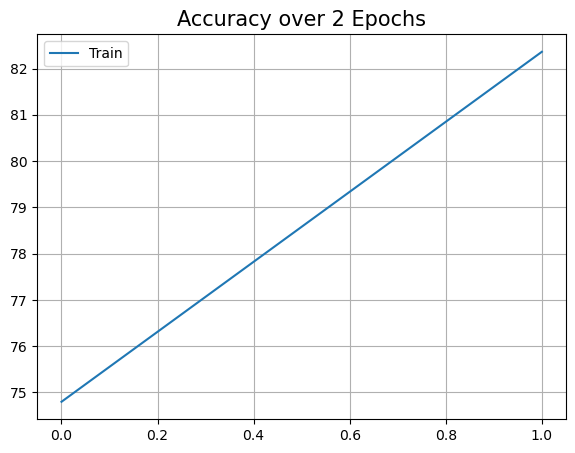

In [44]:
plot_acc(accuracy_point,num_epoch) 